# Predictive maintenance

## Part 3: Inference

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np

import pylab as plt

from tensorflow import keras as K

import vaex
import vaex.ml
import vaex.ml.metrics

import vaex.formatting
vaex.formatting.ARRAY_TRESHHOLD = 1

### Define scoring metrics

In [2]:
def score_func(df, y_true, y_pred):
    print(f'mean absolute error: {np.round(df.ml.metrics.mean_absolute_error(y_true, y_pred), decimals=3)}')
    print(f'mean squared error: {np.round(df.ml.metrics.mean_squared_error(y_true, y_pred), decimals=3)}')
    print(f'R2 score: {np.round(df.ml.metrics.r2_score(y_true, y_pred), decimals=3)}')
    print()    
    
def r2_keras(y_true, y_pred):
    SS_res =  K.backend.sum(K.backend.square(y_true - y_pred))
    SS_tot = K.backend.sum(K.backend.square(y_true - K.backend.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.backend.epsilon()))

### Load the data

In [3]:
df_test = vaex.open('./data/data_test.hdf5')
df_test._future()

df_test

#,unit_number,time_in_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.9,2388.04,9050.17,1.3,47.2,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.5,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.5,521.97,2388.03,8130.1,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.9,8.3917,0.03,391,2388,100.0,39.0,23.3737,139
4,1,5,0.0014,0.0,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.413,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"13,091",100,194,0.0049,0.0,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.0,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
"13,092",100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.6,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
"13,093",100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
"13,094",100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


### Transform the incoming production data (in this case the test data)

This is one with a single easy step!

In [4]:
# This is the transformations on per sample / sequence basis
df_test_trans = df_test.pipeline.load_and_transform('./model/pipeline.json', trusted=True)

df_test_trans

#,unit_number,time_in_cycles,RUL,minmax_scaled_T24,minmax_scaled_T30,minmax_scaled_T50,minmax_scaled_P30,minmax_scaled_Nf,minmax_scaled_Nc,minmax_scaled_Ps30,minmax_scaled_phi,minmax_scaled_NRf,minmax_scaled_BPR,minmax_scaled_htBleed,minmax_scaled_W31,minmax_scaled_W32,feat_BPR,feat_Ps30,feat_T50,htBleed,Nc,feat_W32,NRf,feat_W31,BPR,Ps30,feat_NRf,T50,W31,feat_P30,feat_Nc,T24,feat_T24,phi,W32,feat_htBleed,T30,Nf,feat_phi,feat_T30,feat_Nf,P30,RUL_target,keras_prediction,pred_value
0,3,1,[194 193 192 ... 147 146 145],0.24698795180721447,0.4115979943318086,0.4412559081701569,0.5716586151368758,0.2575757575759246,0.14322893296239786,0.5119047619047616,0.7484008528784724,0.3676470588236179,0.41592920353982415,0.3333333333333333,0.658914728682172,0.5467453957542511,[0.41592920353982415 0.35936898807233864 0.29549826856483424 ... 0.5071181223547523 0.4243939976914217 0.5475182762601021],[0.5119047619047616 0.35119047619047405 0.3273809523809507 ... 0.43452380952380776 0.4107142857142844 0.4940476190476181],[0.4412559081701569 0.4329844699527361 0.42758271438217293 ... 0.49527346387575816 0.4134031060094532 0.5104659014179609],392,9053.65,[0.5467453957542511 0.5792211443835207 0.6611837480669208 ... 0.48474623928018934 0.40826655419654323 0.6149304091100792],2388.13,[0.658914728682172 0.5426356589147312 0.4263565891472849 ... 0.5891472868217043 0.5503875968992258 0.4418604651162796],8.433,47.71,[0.3676470588236179 0.29411764705862686 0.30882352941189256 ... 0.30882352941189256 0.29411764705862686 0.27941176470602985],1408.39,38.99,[0.5716586151368758 0.6264090177133711 0.5442834138486373 ... 0.5571658615136821 0.6103059581320468 0.4380032206119261],[0.14322893296239786 0.08866552992910422 0.14206228125280343 ... 0.1571838822579223 0.11554339046935265 0.14542762272278456],642.03,[0.24698795180721447 0.30722891566265104 0.5331325301204867 ... 0.31626506024095624 0.32530120481926145 0.42469879518072146],522.2,23.296,[0.3333333333333333 0.4166666666666667 0.25 ... 0.4166666666666667 0.5 0.4166666666666667],1589.92,2388.07,[0.7484008528784724 0.5330490405117339 0.6886993603411397 ... 0.6737739872068247 0.6076759061833571 0.6076759061833571],[0.4115979943318086 0.5727054719860456 0.3429256594724216 ... 0.3398735557008961 0.4754741661216457 0.417048179638109],[0.2575757575759246 0.31818181818194347 0.2424242424240754 ... 0.2727272727270848 0.33333333333310367 0.31818181818194347],553.4,145,[115.773],116
1,3,2,[193 192 191 ... 146 145 144],0.30722891566265104,0.5727054719860456,0.4329844699527361,0.6264090177133711,0.31818181818194347,0.08866552992910422,0.35119047619047405,0.5330490405117339,0.29411764705862686,0.35936898807233864,0.4166666666666667,0.5426356589147312,0.5792211443835207,[0.35936898807233864 0.29549826856483424 0.44209311273566926 ... 0.4243939976914217 0.5475182762601021 0.40207772220084576],[0.35119047619047405 0.3273809523809507 0.4821428571428544 ... 0.4107142857142844 0.4940476190476181 0.3273809523809507],[0.4329844699527361 0.42758271438217293 0.32359891964888704 ... 0.4134031060094532 0.5104659014179609 0.4041188386225532],393,9041.49,[0.5792211443835207 0.6611837480669208 0.6474061577393488 ... 0.40826655419654323 0.6149304091100792 0.5408407141852917],2388.08,[0.5426356589147312 0.4263565891472849 0.44961240310077416 ... 0.5503875968992258 0.4418604651162796 0.3565891472868226],8.4183,47.44,[0.29411764705862686 0.30882352941189256 0.30882352941189256 ... 0.29411764705862686 0.27941176470602985 0.3529411764703522],1407.9,38.84,[0.6264090177133711 0.5442834138486373 0.5571658615136821 ... 0.6103059581320468 0.4380032206119261 0.4589371980676422],[0.08866552992910422 0.14206228125280343 0.13147267342726832 ... 0.11554339046935265 0.14542762272278456 0.10477429776541462],642.23,[0.30722891566265104 0.5331325301204867 0.3644578313252849 ... 0.32530120481926145 0.42469879518072146 0.42168674698795305],521.19,23.3191,[0.4166666666666667 0.25 0.5833333333333334 ... 0.5 0.4166666666666667 0.4166666666666667],1597.31,2388.11,[

In [5]:
# This is the transformation done to obtain the final predictions on per engine basis
df_test_final = df_test.pipeline.load_and_transform('./model/pipeline_final.json', trusted=True)

df_test_final

#,unit_number,RUL_pred,RUL_gt,current_cycle
0,3,60,69,77
1,4,84,82,57
2,5,79,91,49
3,6,118,93,56
4,7,110,91,111
...,...,...,...,...
87,96,119,137,48
88,97,102,82,85
89,98,83,59,72
90,99,120,117,48


### Statistics on the Test set:

Score on per sequence basis on the test set:
mean absolute error: 26.983
mean squared error: 1540.833
R2 score: 0.435

Score on the test set - final results!
mean absolute error: 10.783
mean squared error: 223.435
R2 score: 0.868

Score on the test set - for engines with a failure within the next 50 cycles.
mean absolute error: 3.333
mean squared error: 25.867
R2 score: 0.791



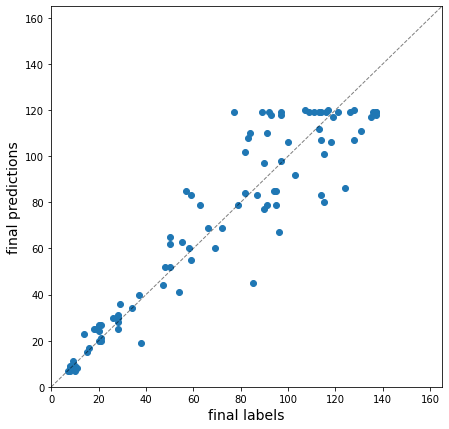

In [6]:
print('Score on per sequence basis on the test set:')
score_func(df_test_trans, 'RUL_target', 'pred_value')

print('Score on the test set - final results!')
score_func(df_test_final, 'RUL_gt', 'RUL_pred')

print('Score on the test set - for engines with a failure within the next 50 cycles.')
score_func(df_test_final[df_test_final.RUL_gt<50], 'RUL_gt', 'RUL_pred')

plt.figure(figsize=(7, 7))
df_test_final.viz.scatter('RUL_gt', 'RUL_pred')
plt.plot([0, 165], [0, 165], lw=1, ls='--', color='black', alpha=0.5)
plt.xlabel('final labels', fontsize=14)
plt.ylabel('final predictions', fontsize=14)
plt.xlim(0, 165)
plt.ylim(0, 165)
plt.show()

### Export data - ready for serving!

In [7]:
df_test_trans.export_hdf5('./data/df_test_trans.hdf5')
df_test_final.export_hdf5('./data/df_test_final.hdf5')

### End